# Predictors of Retail Wine Prices (2019)
### By Andrew J. Flighty


# Introduction

Continuing on from the Australian Vineyard project, this notebook presents a comprehensive analysis of features associated with retail wine prices. Wines vary considerably on myriad features, including variety, vintage, body, and region of origin. Businesses may wish to understand the extent to which these factors influence the pricing of their competitor's products, as this could inform their product pricing strategies.

The aim of this project is to determine these relationships between wine features and retail price, with a particular focus on the popular wine retailer Dan Murphy's.

## Approach

To achieve this aim, the following workflow is implemented:

1. Scrape product data from danmurphys.com.au
2. Import and pre-process dataset
3. Perform exploratory data analysis
4. Build a predictive model of wine price
5. Interpret results and draw conclusions

### Library imports

In [1]:
import numpy as np
import pandas as pd
import re

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn

# Print all columns
pd.set_option('display.max_columns', None)

## Dataset


We will scrape the html directly from Dan Murphy's <a href="https://www.danmurphys.com.au/">online store</a>. Given this is a JavaScript loaded webpage, we will need to make use of the python library Selenium, in addition to BeautifulSoup. 

Key information for each wine include its price (AUD), variety, vintage, alcohol volume (%), and region of origin. Examples of less commonly given information are its closure (e.g. corkscrew, screwcap), whether or not the product is vegan, and any distinguishing awards (e.g. Langton's classification).

For this analysis, we will again focus on four popular _red_ wines (cabernet sauvignon, merlot, pinot noir, shiraz) and four popular _white_ wines (chardonnay, pinot gris, riesling, sauvignon blanc).

## Webscraping

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import os
import time

# Webscraper
class WebScraper():
    """
    A class for scraping wine listings off Dan Murphy's website.
    """    
    def scrape(url, start_pg, end_pg):
        driver = webdriver.Chrome() # create a new Chrome session
        driver.implicitly_wait(30) # wait up to 30 seconds for elements to load
        for page_no in range(start_pg, end_pg):
            df = pd.DataFrame() # create an empty dataframe to be filled
            print('Current page:', page_no)
            driver.get(url)
            time.sleep(1)
            number_of_imgs = len(driver.find_elements_by_xpath("//img[contains(@src, 'https://media.danmurphys.com.au/dmo/product/')]"))
            print(f'Number of images on page {page_no}: {number_of_imgs}')
            for img_no in range(0, number_of_imgs):
                print('Current index:', img_no)
                # Find image links on page
                img_links = driver.find_elements_by_xpath("//img[contains(@src, 'https://media.danmurphys.com.au/dmo/product/')]")
                # Click the next image link
                try:
                    img_links[img_no].click()
                except:
                    print('Failed to scrape '+str(img_no))
                    continue
                # Wait for page to load
                time.sleep(1) 
                # Obtain html
                innerHTML = driver.execute_script("return document.body.innerHTML") # returns the inner HTML as a string
                soup = BeautifulSoup(innerHTML, 'lxml')
                # Find elements of interest
                items = soup.find_all('span', {'class':'item'}) 
                items_values = soup.find_all('span', {'class':'item_value'})
                name = soup.find('span', {'class':'product-name'})
                if name:
                    name = name.getText() 
                else:
                    name = 'Unknown'
                prices = soup.find_all('p', {'class':'ng-star-inserted'})
                # Append wine attributes to dataframe
                items = ['Name'] + [item.getText() for item in items] + ['Price Option '+str(i) for i in range(len(prices))]
                items_values = [name] + [item.getText() for item in items_values] + [price.getText() for price in prices]
                wine_dict = dict(zip(items, items_values))
                df = df.append(wine_dict, ignore_index=True)
                print('Successfully scraped '+str(img_no))
                # Return back to page with wine list
                driver.get(url)
                time.sleep(1)
            # Save contents of this page before continuing
            df.to_csv(f'scraped_white_wines_page_{page_no}.csv')
            
#scraper = WebScraper()
#scraper.scrape(url = f'https://www.danmurphys.com.au/white-wine/country-australia?page={page_no}&size=120', 0, 18)

The above webscraper took many hours to complete, but we have the outputted dataset saved in advance. We can now import it.

## Data importation and preprocessing

In [3]:
%%time
import glob

# Import Dan Murphy wine data
path = r'C:\Users\ajfli\Portfolio\andrewGit\Personal Projects\Project 2 - Australian Retail Wines\Webscraped data'
all_files = glob.glob(path + "\scraped_*_wines_page_*.csv")
print('Number of files read:', len(all_files))
list_ = []
for file_ in all_files:
    df = pd.read_csv(file_, low_memory=False)
    list_.append(df)

# Merge datasets
df = pd.concat(list_, axis = 0, ignore_index = True)

Number of files read: 56
Wall time: 228 ms


In [4]:
# Inspect dataframe
print(df.shape)
df.sample(3)

(6670, 24)


,Alcohol Volume,Brand Name,Closure,Country,Current Vintage,Langtons Classified,Name,Organic,Price Option 0,Price Option 1,Price Option 2,Price Option 3,Price Option 4,Price Option 5,Price Option 6,Region,Size,Standard Drinks,State,Unnamed: 0,Varietal,Vegan Friendly,Wine Body,Wine Style
6127,13%,Printhie,Screw Cap,Australia,2017*,NaN,Mountain Range Chardonnay,NaN,$16.15 in any six,$193.80 per case of 12,$19.99 per bottle,* Vintages may vary from store to store and wh...,NaN,NaN,NaN,Orange,750mL,7.7,New South Wales,57,Chardonnay,NaN,NaN,Dry
3105,13.0% (2010),Clyde Park,Screw Cap,Australia,2010*,NaN,Estate Pinot Noir,NaN,$19.90 in any six,$238.80 per case of 12,$20.90 per bottle,* Vintages may vary from store to store and wh...,Ranked 11 of 24 Pinot Noir from Geelong,NaN,NaN,NaN,750mL,7.7 (2010),NaN,101,Pinot Noir,NaN,Light Bodied,Dry
4376,13.5%,By Farr,Cork,Australia,2011*,NaN,Sangreal Pinot Noir 2011,NaN,$95.00 in any six,$99.99 per bottle,* Vintages may vary from store to store and wh...,NaN,NaN,NaN,NaN,Geelong,750mL,8.0,Victoria,72,Pinot Noir,NaN,NaN,Dry


In [5]:
# Drop duplicate wine listings
num_of_listings = df.shape[0]
df.drop_duplicates(inplace=True)
print(f'Number of listings removed: {num_of_listings-df.shape[0]}')

Number of listings removed: 66


In [6]:
# Remove wines with unknown 'Name'
num_of_listings = df.shape[0]
df = df[df['Name'] != 'Unknown']
print(f'Number of listings removed: {num_of_listings-df.shape[0]}')

Number of listings removed: 92


In [7]:
# Combine 'Brand Name' and 'Name' into a single column
#df['Name'] = df["Brand Name"] + ' ' + df["Name"]

# Remove percent signs and asterisks from 'Alcohol Volume' and 'Current Vintage', respectively
df['Current Vintage'] = pd.to_numeric(df['Current Vintage'].str.replace('*',''), errors='coerce')
df['Alcohol Volume'] = pd.to_numeric(df['Alcohol Volume'].str.replace('%',''), errors='coerce')

df.head(3)

,Alcohol Volume,Brand Name,Closure,Country,Current Vintage,Langtons Classified,Name,Organic,Price Option 0,Price Option 1,Price Option 2,Price Option 3,Price Option 4,Price Option 5,Price Option 6,Region,Size,Standard Drinks,State,Unnamed: 0,Varietal,Vegan Friendly,Wine Body,Wine Style
0,14.0,Barossa Valley Estate,Screw Cap,Australia,2016.0,NaN,Shiraz,NaN,$22.80 in any six,$136.80 per case of 6,$23.99 per bottle,* Vintages may vary from store to store and wh...,NaN,NaN,NaN,Barossa,750mL,8.3,South Australia,0,Shiraz,NaN,Full Bodied,Dry
1,14.5,Secret Selection,Screw Cap,Australia,2017.0,NaN,McLaren Vale Shiraz 2017,NaN,Online Offer$29.00 per bottle,$57.00 in any six,$342.00 per case of 6,$59.99 per bottle,NaN,NaN,NaN,McLaren Vale,750mL,8.6,South Australia,1,Shiraz,NaN,NaN,NaN
2,14.5,Secret Selection,Screw Cap,Australia,2016.0,NaN,Single Vineyard McLaren Vale Shiraz 2016,NaN,Online Offer$29.90 per bottle,$74.99 per bottle,$427.80 per case of 6,$71.30 in any six,NaN,NaN,NaN,McLaren Vale,750mL,8.6,South Australia,2,Shiraz,NaN,NaN,Dry


In [8]:
# Get rows with missing Vintage
missing_vintages = df[df['Current Vintage'].isnull()]['Current Vintage']
# Extract Vintage substring from Name if between 1900-2019
digits = df['Name'].str.extract('(19[09][0-9]|20[0-4][0-9]|2019)')
digits = digits[digits.notnull()]
# Merge Vintage with digit information, where available
df1 = pd.DataFrame(missing_vintages)
df2 = pd.DataFrame(digits)
result = pd.merge(df1, df2, how='inner', left_index=True, right_index=True)[0]
# Modify rows where the Vintage was nan
df.loc[result.index,'Current Vintage'] = result
# Convert vintage to numerical
df['Current Vintage'] = pd.to_numeric(df['Current Vintage'], errors='coerce')

# Change to 'Not specified' for all relevant wine listings, instead of leaving as null
features = ['Vegan Friendly','Closure','Organic','Langtons Classified','Wine Body','Wine Style']
for feature in features:
    df.loc[df[feature].isnull(), feature] = 'Not specified'  
# Change Closure listings with '*' to not specified
df['Closure'] = df['Closure'].apply(lambda x: x.replace('*','Not specified'))

df.head(3)

,Alcohol Volume,Brand Name,Closure,Country,Current Vintage,Langtons Classified,Name,Organic,Price Option 0,Price Option 1,Price Option 2,Price Option 3,Price Option 4,Price Option 5,Price Option 6,Region,Size,Standard Drinks,State,Unnamed: 0,Varietal,Vegan Friendly,Wine Body,Wine Style
0,14.0,Barossa Valley Estate,Screw Cap,Australia,2016.0,Not specified,Shiraz,Not specified,$22.80 in any six,$136.80 per case of 6,$23.99 per bottle,* Vintages may vary from store to store and wh...,NaN,NaN,NaN,Barossa,750mL,8.3,South Australia,0,Shiraz,Not specified,Full Bodied,Dry
1,14.5,Secret Selection,Screw Cap,Australia,2017.0,Not specified,McLaren Vale Shiraz 2017,Not specified,Online Offer$29.00 per bottle,$57.00 in any six,$342.00 per case of 6,$59.99 per bottle,NaN,NaN,NaN,McLaren Vale,750mL,8.6,South Australia,1,Shiraz,Not specified,Not specified,Not specified
2,14.5,Secret Selection,Screw Cap,Australia,2016.0,Not specified,Single Vineyard McLaren Vale Shiraz 2016,Not specified,Online Offer$29.90 per bottle,$74.99 per bottle,$427.80 per case of 6,$71.30 in any six,NaN,NaN,NaN,McLaren Vale,750mL,8.6,South Australia,2,Shiraz,Not specified,Not specified,Dry


In [9]:
# Remove listings with null value for Vintage
num_of_listings = df.shape[0]
df = df[df['Current Vintage'].notnull()]
print(f'Number of listings removed: {num_of_listings-df.shape[0]}')

Number of listings removed: 566


In [10]:
# Calculate prices of wine per bottle
df_prices = pd.DataFrame()
for i in range(0, 7):
    # Overwrite offers (either through membership/delivery/online) in preference for ordinary prices
    # Also overwrite references to pack, cases or cans because they are not of interest
    if df['Price Option '+str(i)].str.contains('Offer|pack|case|can').any():
        df.loc[df['Price Option '+str(i)].str.contains('Offer|case|pack|case|can', na=False), 'Price Option '+str(i)] = np.nan
    # Find where the price per "bottle" is mentioned, and combine these indexes into a new series
    contains_bottle = df['Price Option '+str(i)].str.contains('bottle', na=False)
    df_prices = pd.concat([df_prices, df[contains_bottle]['Price Option '+str(i)]], axis=0)
    
# Extract only numbers and their decimals from Standard Drinks
df['Standard Drinks'] = df['Standard Drinks'].str.extract('(0\.[1-9]|[1-9]\.[0-9]|[1-9][0-9]\.[0-9]|[1-9][0-9][0-9]\.[0-9])')
# Convert Standard Drinks to floats
df['Standard Drinks'] = pd.to_numeric(df['Standard Drinks'], errors='coerce')    

# Add the price per bottle series to the dataframe
df['Price'] = df_prices
# Remove wines with no prices listed
df.dropna(axis=0, subset=['Price'], inplace=True)
# Remove all commas for thousands markers
df['Price'] = df['Price'].str.replace(',', '')
# Remove all non-digit characters from prices
df['Price'] = df['Price'].apply(lambda x: re.findall(r'[-+]?\d*\.\d+|\d+', x).pop()) 
# Convert prices to floats
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
# Drop original price columns, as they are no longer needed
df = df.drop(columns=['Price Option 0', 
                            'Price Option 1', 
                            'Price Option 2', 
                            'Price Option 3', 
                            'Price Option 4', 
                            'Price Option 5',
                            'Price Option 6'], axis=1)
df.head(3)

,Alcohol Volume,Brand Name,Closure,Country,Current Vintage,Langtons Classified,Name,Organic,Region,Size,Standard Drinks,State,Unnamed: 0,Varietal,Vegan Friendly,Wine Body,Wine Style,Price
0,14.0,Barossa Valley Estate,Screw Cap,Australia,2016.0,Not specified,Shiraz,Not specified,Barossa,750mL,8.3,South Australia,0,Shiraz,Not specified,Full Bodied,Dry,23.99
1,14.5,Secret Selection,Screw Cap,Australia,2017.0,Not specified,McLaren Vale Shiraz 2017,Not specified,McLaren Vale,750mL,8.6,South Australia,1,Shiraz,Not specified,Not specified,Not specified,59.99
2,14.5,Secret Selection,Screw Cap,Australia,2016.0,Not specified,Single Vineyard McLaren Vale Shiraz 2016,Not specified,McLaren Vale,750mL,8.6,South Australia,2,Shiraz,Not specified,Not specified,Dry,74.99


In [11]:
# Convert Vintage to int
df['Current Vintage'] = df['Current Vintage'].fillna(-1).astype(int).replace(-1, np.nan)

In [12]:
# Replace litres with millilitres
df['Size'].replace('1.5L', '1000', inplace=True)
df['Size'].replace('6L', '6000', inplace=True)
df['Size'].replace('1L', '1000', inplace=True)
df['Size'].replace('5L', '5000', inplace=True)

# Remove two listing with unusual Alcohol Volumes
df = df[df['Alcohol Volume'] != 145]
df = df[df['Alcohol Volume'] != 1450]

# Remove one listing with unusual Standard Drinks
df = df[df['Standard Drinks'] != 66.4]

# Remove one listing with an unusual Size
df = df[df['Size'] != 'B']
# Remove all non-digit characters from sizes
df['Size'] = df['Size'].apply(lambda x: re.findall(r'[-+]?\d*\.\d+|\d+', x).pop() if pd.notnull(x) else x)
# Convert sizes to floats
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

In [13]:
# Drop unneeded columns
df = df.drop(columns=['Name','Country','Unnamed: 0',], axis=1)

In [14]:
# Create new column for wine type (Red or White)
reds = ['Shiraz', 'Cabernet Sauvignon', 'Pinot Noir','Merlot']
whites = ['Riesling', 'Chardonnay', 'Pinot Gris','Sauvignon Blanc']

for idx in range(len(df)):
    if df['Varietal'].iloc[idx] in reds:
        df.at[idx,'Type'] = 'Red'
    elif df['Varietal'].iloc[idx] in whites:
        df.at[idx,'Type'] = 'White'
df.head(3)

,Alcohol Volume,Brand Name,Closure,Current Vintage,Langtons Classified,Organic,Region,Size,Standard Drinks,State,Varietal,Vegan Friendly,Wine Body,Wine Style,Price,Type
0,14.0,Barossa Valley Estate,Screw Cap,2016.0,Not specified,Not specified,Barossa,750.0,8.3,South Australia,Shiraz,Not specified,Full Bodied,Dry,23.99,Red
1,14.5,Secret Selection,Screw Cap,2017.0,Not specified,Not specified,McLaren Vale,750.0,8.6,South Australia,Shiraz,Not specified,Not specified,Not specified,59.99,Red
2,14.5,Secret Selection,Screw Cap,2016.0,Not specified,Not specified,McLaren Vale,750.0,8.6,South Australia,Shiraz,Not specified,Not specified,Dry,74.99,Red


In [15]:
wine_varieties = ['Cabernet Sauvignon', 'Merlot', 'Pinot Noir', 'Shiraz', 'Chardonnay', 'Pinot Gris', 'Riesling', 'Sauvignon Blanc']

# Only select wines that belong to our wine list
num_of_listings = df.shape[0]
df = df[df['Varietal'].str.contains('|'.join(wine_varieties), na=False)]
print(f'Number of listings removed: {num_of_listings-df.shape[0]}')

# Set the wine variety to items of the above list if their name hints at it
for wine in wine_varieties:
    df.loc[df['Varietal'].str.contains(wine), 'Varietal'] = wine

Number of listings removed: 1584


In [16]:
# Rename columns
df.rename(columns={
 'Alcohol Volume':
 'Alcohol Volume (%)',
    
 'Current Vintage':
 'Vintage',
    
 'Size':
 'Size (mL)',
    
 'Varietal':
 'Variety',
    
 'Price':
 'Price (AUD)'}, inplace=True)

# Reorder columns
cols = ['Brand Name',
        'Price (AUD)',
        'Variety',
        'Type',
        'Region',
        'State',
        'Vintage',
        'Size (mL)',
        'Alcohol Volume (%)',
        'Standard Drinks',
        'Organic',
        'Vegan Friendly',
        'Wine Body',
        'Wine Style',
        'Closure',
        'Langtons Classified']
df = df[cols]

# Reset index
df.reset_index(drop=True)

print(f'Number of listings: {df.shape[0]}')
df.head(3)

Number of listings: 4597


,Brand Name,Price (AUD),Variety,Type,Region,State,Vintage,Size (mL),Alcohol Volume (%),Standard Drinks,Organic,Vegan Friendly,Wine Body,Wine Style,Closure,Langtons Classified
0,Barossa Valley Estate,23.99,Shiraz,Red,Barossa,South Australia,2016.0,750.0,14.0,8.3,Not specified,Not specified,Full Bodied,Dry,Screw Cap,Not specified
1,Secret Selection,59.99,Shiraz,Red,McLaren Vale,South Australia,2017.0,750.0,14.5,8.6,Not specified,Not specified,Not specified,Not specified,Screw Cap,Not specified
2,Secret Selection,74.99,Shiraz,Red,McLaren Vale,South Australia,2016.0,750.0,14.5,8.6,Not specified,Not specified,Not specified,Dry,Screw Cap,Not specified


In [17]:
# Save cleaned dataset
df.to_csv('Wine_data.csv')

## Exploratory data analysis

In [18]:
df.describe()

,Price (AUD),Vintage,Size (mL),Alcohol Volume (%),Standard Drinks
count,4597.000000,4597.000000,4582.000000,3508.000000,4050.000000
mean,141.044137,2011.017620,754.912484,13.727948,8.193185
std,1310.558020,7.311745,119.455815,0.966014,1.151259
min,2.490000,1952.000000,187.000000,7.000000,1.200000
25%,18.000000,2008.000000,750.000000,13.200000,7.700000
50%,29.950000,2014.000000,750.000000,14.000000,8.300000
75%,69.990000,2016.000000,750.000000,14.500000,8.600000
max,36000.000000,2018.000000,6000.000000,18.500000,19.200000


In [19]:
# Check missing values
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_application_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
del missing_application_data.index.name
missing_application_data.head(12)

,Total,Percent Missing
Type,1906,41.461823
Alcohol Volume (%),1089,23.689363
Region,844,18.359800
Standard Drinks,547,11.899065
State,381,8.288014
Size (mL),15,0.326300
Langtons Classified,0,0.000000
Closure,0,0.000000
Wine Style,0,0.000000
Wine Body,0,0.000000


A sizeable proportion of wines have no alcohol volume, region, standard drinks, or state listed.

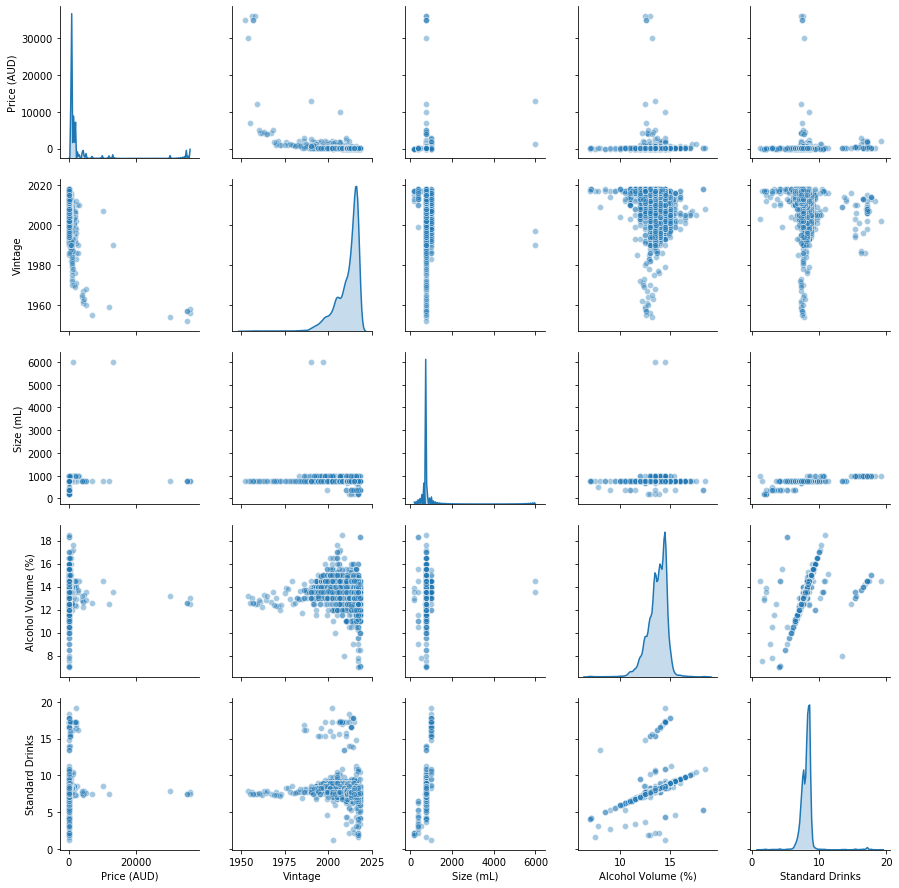

In [20]:
# Plot pairwise associations between quantitative features
sns.pairplot(df.drop(columns=['Organic', 'Vegan Friendly']), diag_kind='kde', palette='Greens',
             plot_kws={'alpha':0.4},
             diag_kws={'shade':True}, size=2.5);

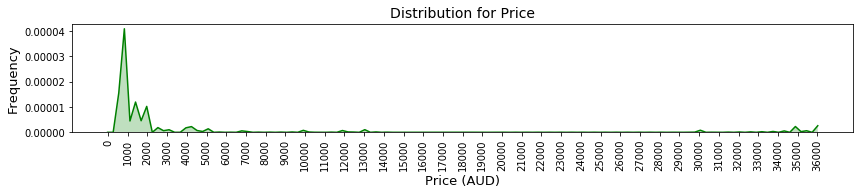

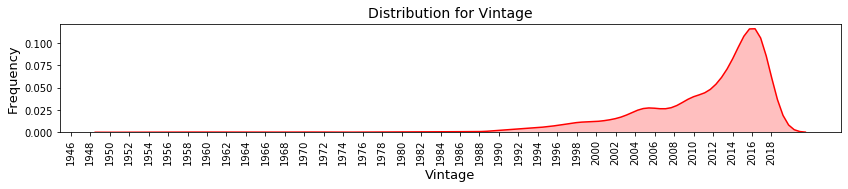

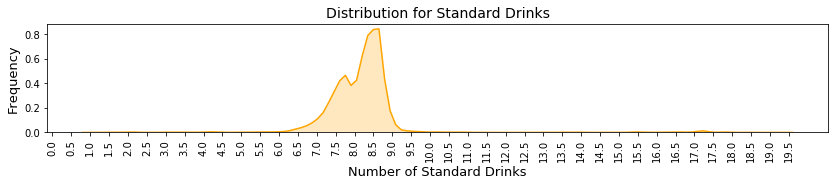

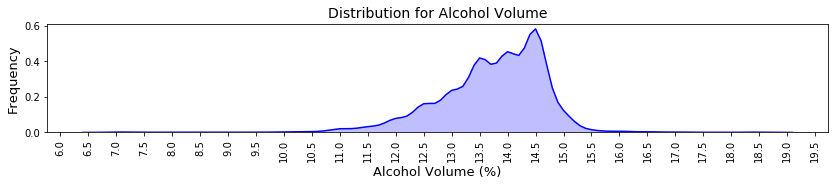

In [21]:
# Plot distribution for wine prices
plt.figure(figsize=(14,2))
plt.title('Distribution for Price', fontsize=14)
plt.xlabel('Price (AUD)', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(np.arange(0, 36500, step=1000), rotation=90)
sns.kdeplot(df['Price (AUD)'], shade=True, legend=False, color='green');

# Plot distribution for Vintage
plt.figure(figsize=(14,2))
plt.title('Distribution for Vintage', fontsize=14)
plt.xlabel('Vintage', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(np.arange(1940, 2020, step=2), rotation=90)
sns.kdeplot(df['Vintage'], shade=True, legend=False, color='red');
plt.show()

# Plot distribution for Standard Drinks
plt.figure(figsize=(14,2))
plt.title('Distribution for Standard Drinks', fontsize=14)
plt.xlabel('Number of Standard Drinks', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(np.arange(0, 20, step=0.5), rotation=90)
sns.kdeplot(df['Standard Drinks'], shade=True, legend=False, color='orange');
plt.show()

# Plot distribution for Alcohol Volume
plt.figure(figsize=(14,2))
plt.title('Distribution for Alcohol Volume', fontsize=14)
plt.xlabel('Alcohol Volume (%)', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(np.arange(0, 20, step=0.5), rotation=90)
sns.kdeplot(df['Alcohol Volume (%)'], shade=True, legend=False, color='blue');
plt.show()

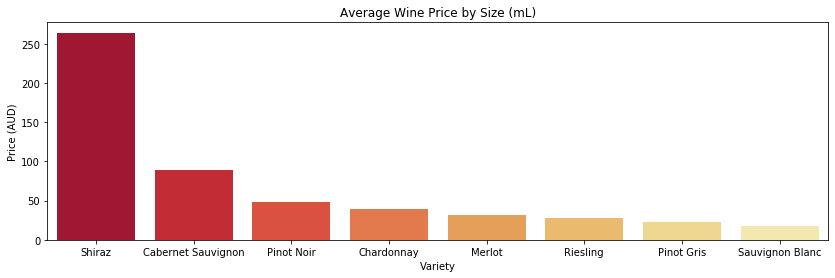

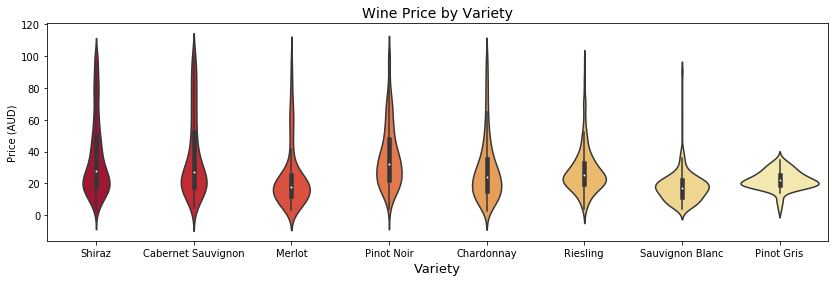

In [22]:
# Plot bar plot of price vs. Variety
mean_price_per_category = df.groupby('Variety').mean().reset_index()
sorted_df = mean_price_per_category.sort_values(by='Price (AUD)', ascending=False)
sorted_df = sorted_df[sorted_df['Variety'] != 6000.0]
plt.figure(figsize=(14,4))
ax = sns.barplot(sorted_df['Variety'], sorted_df['Price (AUD)'], estimator=np.mean, ci=95, palette='YlOrRd_r');
ax.set_title(f'Average Wine Price by Size (mL)')
plt.show()

# Plot violin plot of price vs. Variety, ignoring wine prices > $100
plt.figure(figsize=(14,4))
plt.title("Wine Price by Variety", fontsize=14)
plt.xlabel('Price (AUD)', fontsize=13)
plt.xticks(np.arange(0, 650, step=10))
sns.violinplot(x='Variety', y='Price (AUD)', data=df[df['Price (AUD)'] <= 100], palette='YlOrRd_r'); 
plt.show()

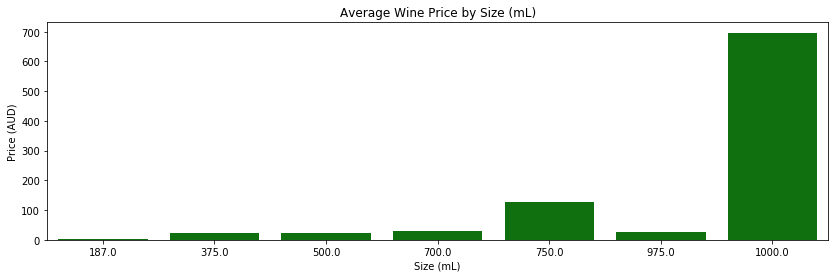

In [23]:
# Plot mean price vs. Size
mean_price_per_category = df.groupby('Size (mL)').mean().reset_index()
sorted_df = mean_price_per_category.sort_values(by='Price (AUD)', ascending=False)
sorted_df = sorted_df[sorted_df['Size (mL)'] != 6000.0]
plt.figure(figsize=(14,4))
ax = sns.barplot(sorted_df['Size (mL)'], sorted_df['Price (AUD)'], estimator=np.mean, ci=95, color='green');
ax.set_title(f'Average Wine Price by Size (mL)')
plt.show()

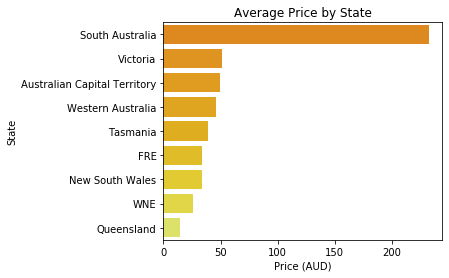

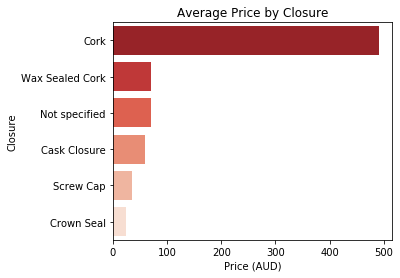

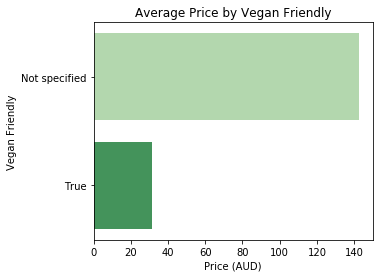

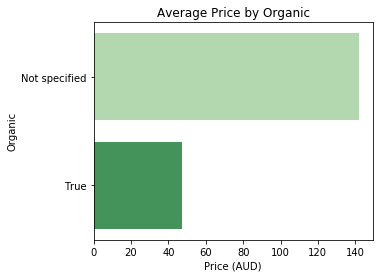

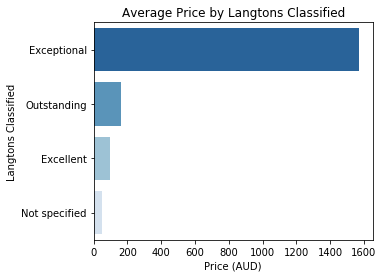

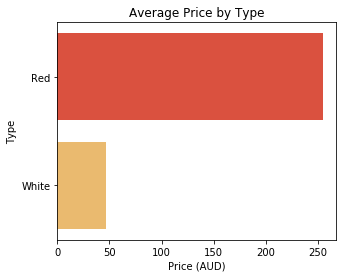

In [24]:
# Plot mean price vs. a range of other features
features = ['State','Closure','Vegan Friendly','Organic','Langtons Classified','Type']
colours = iter(['Wistia_r','Reds_r','Greens','Greens','Blues_r','YlOrRd_r'])
for feature in features:
    mean_price_per_category = df.groupby(feature).mean().reset_index()
    sorted_df = mean_price_per_category.sort_values(by='Price (AUD)', ascending=False)
    plt.figure(figsize=(5,4))
    ax = sns.barplot(sorted_df['Price (AUD)'], sorted_df[feature], estimator=np.mean, ci=95, palette=next(colours));
    ax.set_title(f'Average Price by {feature}')
    plt.show()

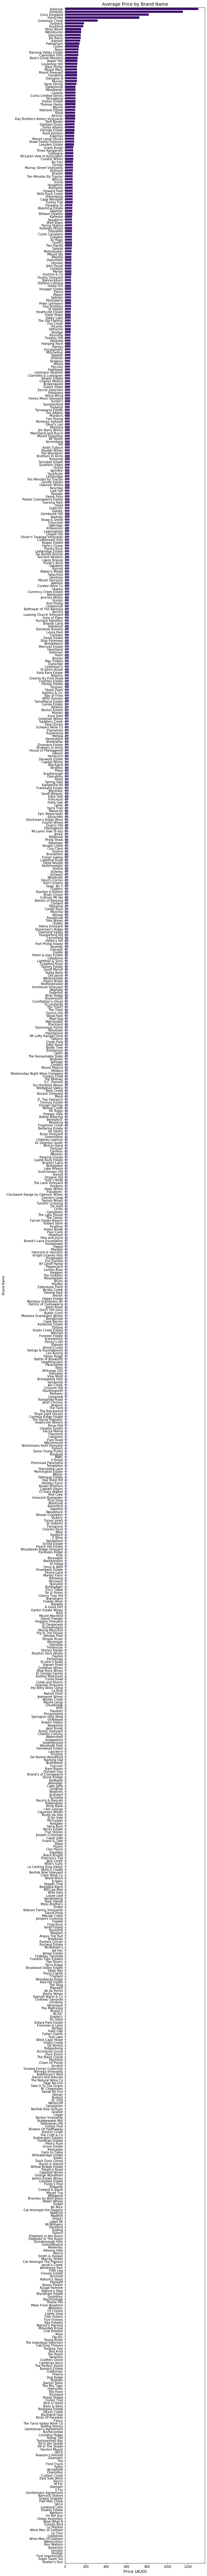

In [25]:
# Plot mean price vs. Brand Name
mean_price_per_state = df.groupby('Brand Name').mean().reset_index()
sorted_df = mean_price_per_state.sort_values(by='Price (AUD)', ascending=False)
plt.figure(figsize=(8,150))
plt.title("Average Price by Brand Name", fontsize=14)
plt.xlabel('Mean Price (AUD)', fontsize=13)
sns.barplot(x='Price (AUD)', y='Brand Name', data=sorted_df, orient='h', estimator=np.mean, palette='Purples_r');
plt.show()

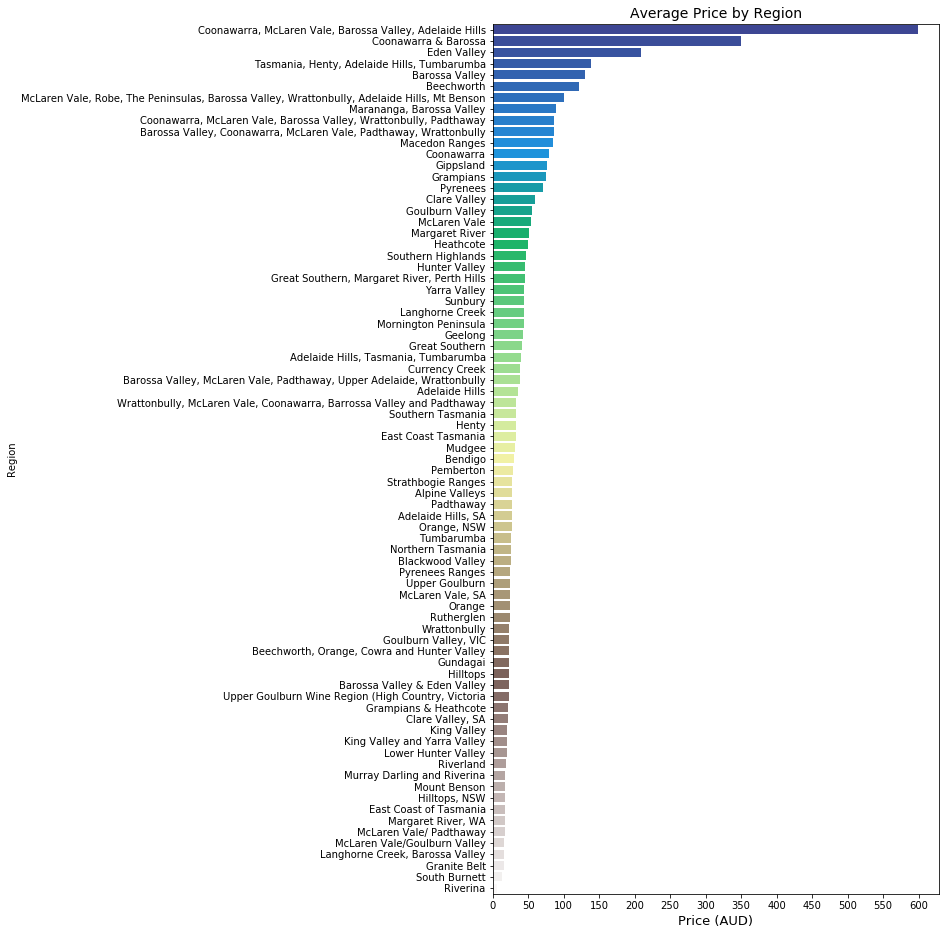

In [26]:
# Only select wines that match our list of Australian wine regions used in the previous project
region_list = ['Murray Darling (NSW)', 'Perricoota', 'Riverina', 'Swan Hill (NSW)',
 'Big Rivers - Other', 'Western Plains', 'Cowra', 'Mudgee', 'Orange',
 'Central Ranges - Other', 'Canberra District (NSW)', 'Hilltops',
 'Tumbarumba', 'Gundagai', 'Southern New South Wales - Other',
 'Shoalhaven Coast', 'Southern Highlands', 'South Coast - Other',
 'New England Australia', 'Northern Slopes', 'Hastings River',
 'Northern Rivers - Other', 'Hunter', 'Hunter Valley - Other',
 'Murray Darling (Vic.)', 'Swan Hill (Vic.)', 'North West Victoria - Other',
 'Alpine Valleys', 'Beechworth', 'Rutherglen', 'Glenrowan', 'King Valley',
 'North East Victoria - Other', 'Bendigo', 'Goulburn Valley',
 'Strathbogie Ranges', 'Heathcote', 'Upper Goulburn',
 'Central Victoria - Other', 'Grampians', 'Henty', 'Pyrenees',
 'Western Victoria - Other', 'Geelong', 'Mornington Peninsula', 'Sunbury',
 'Yarra Valley', 'Macedon Ranges', 'Port Phillip - Other', 'Gippsland',
 'Granite Belt', 'South Burnett', 'Queensland - Other', 'Adelaide Hills',
 'Clare Valley', 'Adelaide Plains', 'Mount Lofty Ranges - Other',
 'Barossa Valley', 'Eden Valley', 'Barossa - Other', 'Currency Creek',
 'Kangaroo Island', 'Langhorne Creek', 'McLaren Vale', 'Southern Fleurieu',
 'Fleurieu - Other', 'Mount Benson', 'Padthaway', 'Coonawarra', 'Wrattonbully',
 'Robe' 'Mount Gambier', 'Limestone Coast - Other', 'Riverland',
 'Lower Murray - Other', 'The Peninsulas', 'Southern Flinders Ranges',
 'Far North - Other', 'Perth Hills', 'Swan Districts', 'Peel'
 'Greater Perth - Other', 'Central Western  Australia', 'Blackwood Valley',
 'Geographe', 'Great Southern', 'Margaret River', 'Manjimup', 'Pemberton',
 'South West Australia - Other', 'West Australia South East Coastal',
 'Eastern Plains, Inland and North of WA', 'Tasmania',
 'Canberra District (ACT)',]

# Remove nan regions
df = df.dropna(subset=['Region'])
# Only select regions that belong to our Australian wine regions list
df = df[df['Region'].str.contains('|'.join(region_list))]

# Plot mean price for each wine region
mean_price_per_region = df.groupby('Region').mean().reset_index()
sorted_df = mean_price_per_region.sort_values(by='Price (AUD)', ascending=False)
plt.figure(figsize=(8,16))
plt.title("Average Price by Region", fontsize=14)
plt.xlabel('Mean Price (AUD)', fontsize=13)
plt.xticks(np.arange(0, 650, step=50))
sns.barplot(x='Price (AUD)', y='Region', data=sorted_df, orient='h', estimator=np.mean, palette='terrain');
plt.show()

Overall, there is considerable variation in price as a function of the above features. This suggests these features may prove useful in building a predictive model of wine price.

We can now examine more complex relationships with price, specifically relating to vintage as well as different grouping factors (Langton's classification, variety).

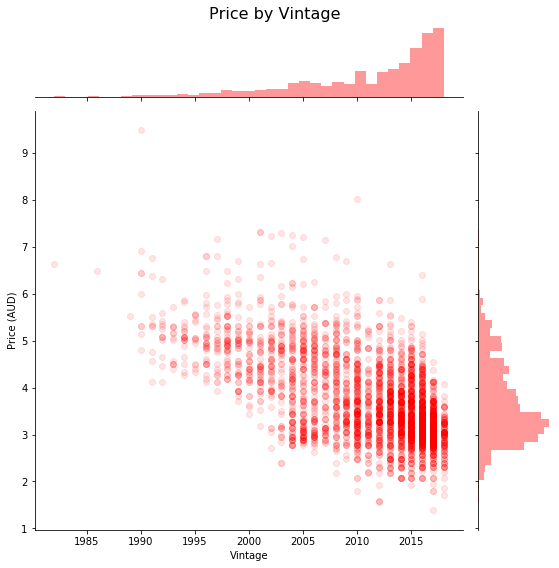

In [27]:
# # Log transform Price
df_transformed = df.copy()
df_transformed['Price (AUD)'] = np.log1p(df['Price (AUD)'])

# Price vs. Vintage
sns.jointplot(x='Vintage', y="Price (AUD)", data=df_transformed[df_transformed['Vintage'] >= 1980],
              kind='scatter', size=8, color='red', alpha=0.1);
plt.subplots_adjust(top=0.95)
plt.suptitle('Price by Vintage', fontsize = 16);

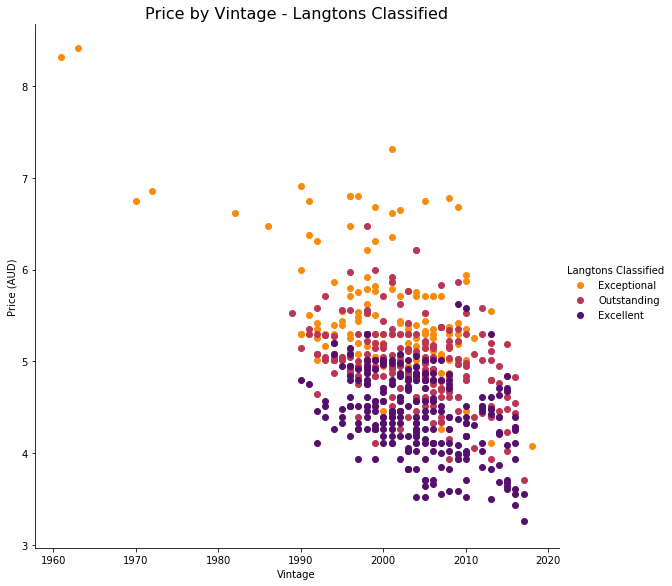

In [28]:
# Price vs. Langtons Classification
sns.lmplot(x='Vintage', y='Price (AUD)', hue='Langtons Classified', hue_order = ['Exceptional', 'Outstanding', 'Excellent'],
           data=df_transformed,
           scatter_kws={'alpha':1}, fit_reg=False, size=8, palette='inferno_r');
ax = plt.gca()
plt.title('Price by Vintage - Langtons Classified', fontsize = 16);

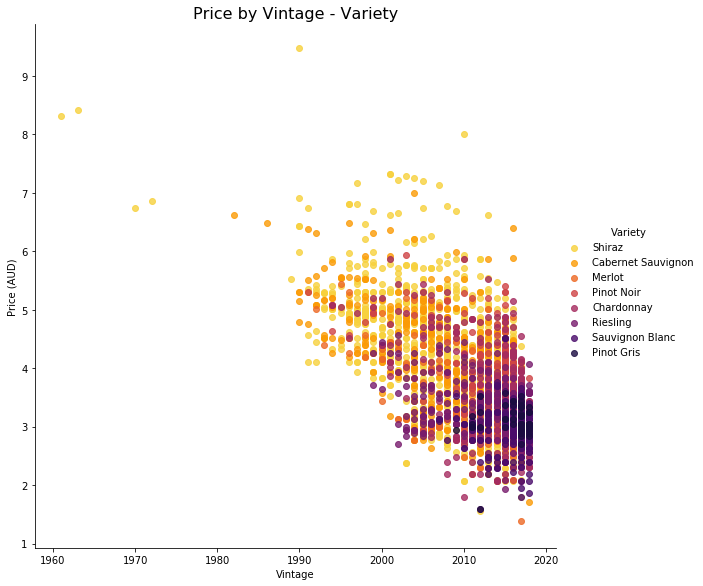

In [29]:
# Price vs. Wine Variety
sns.lmplot(x='Vintage', y='Price (AUD)', hue='Variety',
           data=df_transformed,
           scatter_kws={'alpha':0.8}, fit_reg=False, size=8, palette='inferno_r');
ax = plt.gca()
plt.title('Price by Vintage - Variety', fontsize = 16);

Now we can examine relationships between this dataset and the Australian Vineyard dataset. Specifically, we will examine factors associated with total yield.

In [30]:
# Import vineyard dataset
df_vineyard = pd.read_csv('C:/Users/ajfli/Portfolio/andrewGit/Personal Projects/Project 1 - Australian Vineyard Yield/Datasets/Vineyard_data.csv')

# Reset indices to facilitate table join
df_vineyard.set_index(['Region'], inplace=True)
mean_price_per_region.set_index(['Region'], inplace=True)
# Join tables
df_combined = df_vineyard.join(mean_price_per_region, how='inner')

df_combined.drop(columns=['Unnamed: 0'], inplace=True)
df_combined.head()

,Latitude,Longitude,Total yield (t/ha),Total red yield (t/ha),Total white yield (t/ha),Cabernet sauvignon yield (t/ha),Chardonnay yield (t/ha),Merlot yield (t/ha),Pinot gris yield (t/ha),Pinot noir yield (t/ha),Riesling yield (t/ha),Sauvignon blanc yield (t/ha),Shiraz yield (t/ha),Number of agricultural businesses,Source of water - groundwater (ML),Source of water - irrigation channels or irrigation pipelines (ML),Source of water - other (ML),Source of water - recycled/re-used water from off-farm sources (ML),Source of water - total volume of water used (ML),Source of water - town or country reticulated mains supply (ML),Source of source - water taken from on-farm dams or tanks (ML),"Source of water - water taken from rivers, creeks, lakes, etc. (ML)",Watering method - drip or micro spray - area irrigated (ha),Watering method - furrow or flood - area irrigated (ha),Watering method - method not reported - area irrigated (ha),Watering method - other - area irrigated (ha),Watering method - spray or sprinkler (excluding micro spray) - area irrigated (ha),Price (AUD),Vintage,Size (mL),Alcohol Volume (%),Standard Drinks
Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adelaide Hills,-34.8,138.9,70.21,28.56,41.65,4.42,8.60,8.35,11.72,9.27,11.72,9.61,6.52,543.0,3507.81,100.22,NaN,26.57,4724.52,9.34,936.32,144.26,2711.17,NaN,68.98,NaN,45.47,35.712590,2014.710843,745.481928,13.113281,7.764138
Alpine Valleys,-36.4,146.8,58.98,25.03,33.95,2.76,11.78,8.58,11.54,10.37,3.17,7.46,3.32,60.0,19.80,NaN,NaN,NaN,211.80,14.14,27.52,150.33,118.24,NaN,NaN,NaN,32.70,27.495000,2015.500000,750.000000,13.250000,8.000000
Barossa Valley,-34.5,139.0,54.24,22.69,31.55,3.67,7.60,5.48,8.69,8.54,7.18,8.08,5.00,796.0,2416.12,3045.24,1926.26,261.31,9893.21,1097.72,598.76,547.80,8711.69,NaN,8.56,1.57,31.10,130.624045,2008.916512,755.469274,14.387414,8.674257
Beechworth,-36.3,146.6,49.18,23.72,25.46,7.01,6.73,5.72,8.97,5.33,2.89,6.87,5.66,52.0,5.75,NaN,NaN,NaN,97.21,NaN,91.46,NaN,87.00,NaN,NaN,NaN,6.57,121.988214,2007.232143,767.857143,13.620930,9.045455
Bendigo,-36.7,144.1,37.42,19.02,18.40,3.36,3.41,4.39,6.39,7.18,4.20,4.40,4.09,117.0,15.16,201.86,NaN,27.73,809.64,1.54,171.96,391.38,570.55,1.23,NaN,NaN,1.23,29.510526,2010.684211,750.000000,13.766667,8.253333


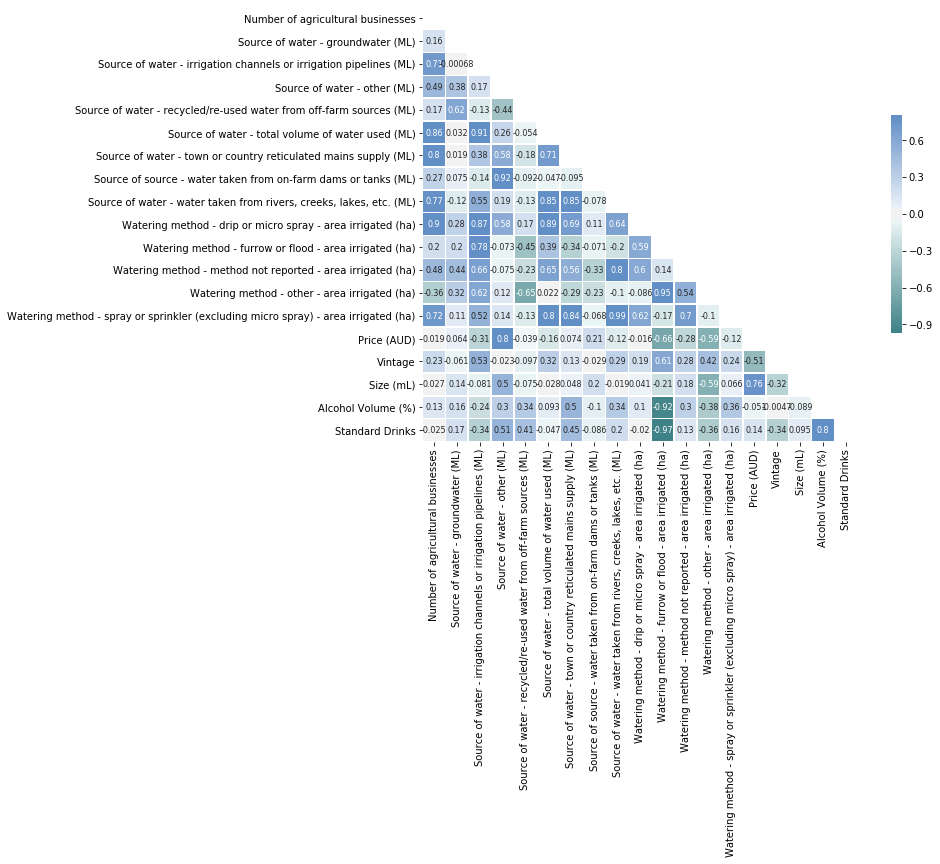

In [31]:
# Plot correlation matrix
corrmat = df_combined.loc[:,'Number of agricultural businesses':].corr()
f, ax = plt.subplots(figsize=(12, 8))
mask = np.zeros_like(corrmat, dtype=np.bool) # generate a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
# Set colour palette
cmap = sns.diverging_palette(200, 250, as_cmap=True)
sns.heatmap(corrmat, vmax=.8, center = 0, mask=mask, square=True, linewidths=.5, annot=True, cmap=cmap,
            cbar_kws={"shrink":0.5}, annot_kws={"size": 8});

# Fix issue whereby heatmap is "cut off"
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);

The correlation matrix suggests that Price is correlated with some watering factors in each region, including 'Source of water - other (ML) and 'Watering method - furrow or flood - area irrigated (ha).'

However, closer inspection of individual scatterplots (below) reveal that these high correlations are due to small sample sizes, which cannot be relied upon. It is thus unlikely that features of the vineyard dataset can be used to model Price.

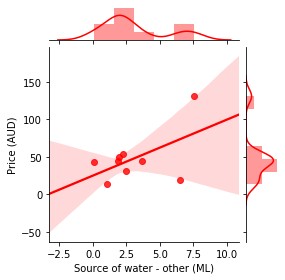

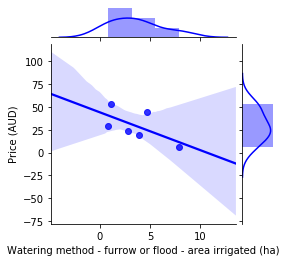

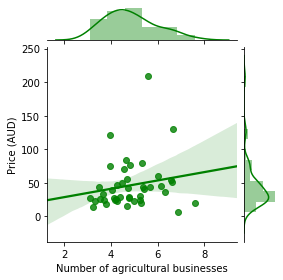

In [32]:
# Visualise relationship between Price and select features from the Vineyard dataset
features = ['Source of water - other (ML)',
            'Watering method - furrow or flood - area irrigated (ha)',
            'Number of agricultural businesses']
colors = iter(['red','blue','green'])

for i, feature in enumerate(features):
    sns.jointplot(np.log1p(df_combined[feature]), df_combined['Price (AUD)'],
                  color=next(colors), size=4, kind='reg');

## Predictive modelling

We will use the following features as predictors in our model of Price. Wine prices greater than $100 AUD are outliers in our dataset, and will be omitted for this analysis.

In [33]:
df.columns

Index(['Brand Name', 'Price (AUD)', 'Variety', 'Type', 'Region', 'State',
       'Vintage', 'Size (mL)', 'Alcohol Volume (%)', 'Standard Drinks',
       'Organic', 'Vegan Friendly', 'Wine Body', 'Wine Style', 'Closure',
       'Langtons Classified'],
      dtype='object')

In [34]:
# Only select wines that cost less than or equal to $100 AUD
df = df[df['Price (AUD)'] <= 100]

In [35]:
# Preprocessing libraries
from sklearn.pipeline import Pipeline, FeatureUnion
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import Imputer, StandardScaler

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.base import BaseEstimator, TransformerMixin
class ColumnSelector(BaseEstimator, TransformerMixin):
    """A custom transformer to select a subset of columns"""
    def __init__(self, subset):
        self.subset = subset

    def transform(self, X, *_):
        return X.loc[:, self.subset]

    def fit(self, *_):
        return self

In [36]:
# Identify features of interest
num_features = ['Vintage', 'Alcohol Volume (%)','Size (mL)']
cat_features = ['Brand Name','State','Region','Wine Body','Wine Style','Closure','Langtons Classified','Variety',
                'Organic','Vegan Friendly','Type']

# Pipeline to preprocess numerical features
num_pipeline = Pipeline([
        ('selector', ColumnSelector(num_features)), 
        ('imputer', Imputer(strategy="median")),           
        ('standardizer', StandardScaler())        
    ])

# Pipeline to preprocess categorical features
cat_pipeline = Pipeline([
        ('selector', ColumnSelector(cat_features)),
        ('ordinal_encoder', OrdinalEncoder()) # more preferable than OHE for decision-tree algorithms
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline),
    ])

# Get response vector
df_y = df['Price (AUD)']
# Get feature matrix
df_X = full_pipeline.fit_transform(df.drop(columns='Price (AUD)'))

# Get train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.10)
print(f'Size of training set: {X_train.shape[0]}')
print(f'Size of test set: {X_test.shape[0]}')

Size of training set: 2634
Size of test set: 293


In [37]:
# # # # RIDGE REGRESSION # # # #
param_grid = [{'alpha': [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 100]}]

# CV hyperparamater tuning for ridge regression
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
ridge_best = grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, param in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE: {np.sqrt(-mean_score)}, {param}')
print(f'\nBest RMSE for ridge regression: {np.sqrt(-cvres["mean_test_score"].max())}')
print(f'Best hyperparameter(s):', grid_search.best_params_)

RMSE: 17.211995522511643, {'alpha': 0.005}
RMSE: 17.211990899378602, {'alpha': 0.01}
RMSE: 17.211954025228373, {'alpha': 0.05}
RMSE: 17.21190820874274, {'alpha': 0.1}
RMSE: 17.21172797556443, {'alpha': 0.3}
RMSE: 17.21113395703425, {'alpha': 1}
RMSE: 17.20972023648132, {'alpha': 3}
RMSE: 17.208665592378853, {'alpha': 5}
RMSE: 17.20725673971899, {'alpha': 10}
RMSE: 17.20720026657315, {'alpha': 15}
RMSE: 17.2125657348542, {'alpha': 30}
RMSE: 17.228071264436274, {'alpha': 50}
RMSE: 17.28745569914369, {'alpha': 100}

Best RMSE for ridge regression: 17.20720026657315
Best hyperparameter(s): {'alpha': 15}


In [38]:
# # # # LASSO REGRESSION # # # #
param_grid = [{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

# CV hyperparamater tuning for lasso regression
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
lasso_best = grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, param in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE: {np.sqrt(-mean_score)}, {param}')
print(f'\nBest RMSE for lasso regression: {np.sqrt(-cvres["mean_test_score"].max())}')
print(f'Best hyperparameter(s):', grid_search.best_params_)

RMSE: 17.21146780155225, {'alpha': 0.001}
RMSE: 17.206680738209478, {'alpha': 0.01}
RMSE: 17.19642379826102, {'alpha': 0.1}
RMSE: 17.452995495483812, {'alpha': 1}
RMSE: 21.727854196086408, {'alpha': 10}
RMSE: 21.82865810241695, {'alpha': 100}
RMSE: 21.998839591210697, {'alpha': 1000}

Best RMSE for lasso regression: 17.19642379826102
Best hyperparameter(s): {'alpha': 0.1}


In [39]:
# # # # RANDOM FOREST REGRESSOR # # # #
param_grid = [
    {'n_estimators': [50, 100, 200, 500],
     'max_features': range(1,10,2)}]

# CV hyperparameter tuning for random forest
rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
rf_best = grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, param in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE: {np.sqrt(-mean_score)}, {param}')
print(f'\nBest RMSE for random forest: {np.sqrt(-cvres["mean_test_score"].max())}')
print(f'Best hyperparameter(s):', grid_search.best_params_)

RMSE: 15.305886870856545, {'max_features': 1, 'n_estimators': 50}
RMSE: 15.310211068262948, {'max_features': 1, 'n_estimators': 100}
RMSE: 15.244772478352573, {'max_features': 1, 'n_estimators': 200}
RMSE: 15.208895098363378, {'max_features': 1, 'n_estimators': 500}
RMSE: 15.052490493115515, {'max_features': 3, 'n_estimators': 50}
RMSE: 14.98594827067533, {'max_features': 3, 'n_estimators': 100}
RMSE: 14.948084134252953, {'max_features': 3, 'n_estimators': 200}
RMSE: 14.912732632694572, {'max_features': 3, 'n_estimators': 500}
RMSE: 14.985612155723704, {'max_features': 5, 'n_estimators': 50}
RMSE: 14.875283608798595, {'max_features': 5, 'n_estimators': 100}
RMSE: 14.838029187022862, {'max_features': 5, 'n_estimators': 200}
RMSE: 14.878380202217778, {'max_features': 5, 'n_estimators': 500}
RMSE: 14.896090018147452, {'max_features': 7, 'n_estimators': 50}
RMSE: 14.965525742931858, {'max_features': 7, 'n_estimators': 100}
RMSE: 14.889589421079537, {'max_features': 7, 'n_estimators': 200}


In [40]:
# # # # XGBOOST REGRESSOR # # # #
param_grid = [
    {'n_estimators': [50, 100, 200, 500],
     'max_depth': range(1,12,2),
     'min_child_weight': range(1,10,2)}]

# CV hyperparameter tuning for random forest
xgb = XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(xgb, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
xgb_best = grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, param in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE: {np.sqrt(-mean_score)}, {param}')
print(f'\nBest RMSE for XGBoost regressor: {np.sqrt(-cvres["mean_test_score"].max())}')
print(f'Best hyperparameter(s):', grid_search.best_params_)

RMSE: 17.24592388661704, {'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 50}
RMSE: 16.916541575791666, {'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100}
RMSE: 16.60772996304037, {'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200}
RMSE: 16.373807649780645, {'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 500}
RMSE: 17.24592388661704, {'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 50}
RMSE: 16.916541575791666, {'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 100}
RMSE: 16.60772996304037, {'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 200}
RMSE: 16.372996767089795, {'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 500}
RMSE: 17.24592388661704, {'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 50}
RMSE: 16.916541575791666, {'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 100}
RMSE: 16.60737730099733, {'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 200}
RMSE: 16.365637963883895, {'max_depth': 1, 'min_chil

RMSE on test dataset: 8.54
R-squared on test dataset: 0.88


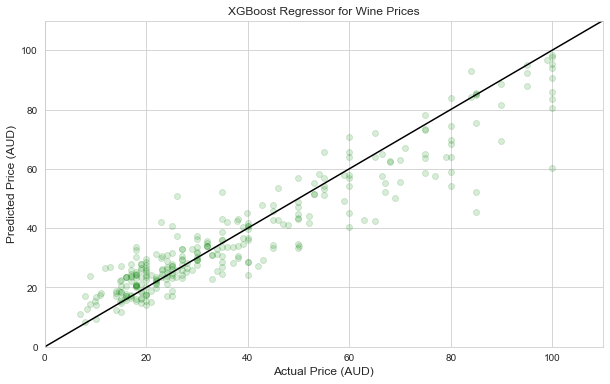

In [43]:
# Predict best model on test set
y_pred = xgb_best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print('RMSE on test dataset:', round(rmse, 2))
r_sq = r2_score(y_test, y_pred)
print('R-squared on test dataset:', round(r_sq, 2))

# Plot actual vs. predicted
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.regplot(y_test, y_pred, ci=None, fit_reg=False, color='green', marker='o',  scatter_kws={'alpha':0.15});
plt.title('XGBoost Regressor for Wine Prices', fontsize=12);
plt.xlabel('Actual Price (AUD)', fontsize=12);
plt.ylabel('Predicted Price (AUD)', fontsize=12);
axis_limit = max(y_test.max(), y_pred.max())+10
plt.xlim(0, axis_limit);
plt.ylim(0, axis_limit);

# Add y=x line, representing perfect prediction accuracy
y_lim = plt.ylim();
x_lim = plt.xlim();
plt.plot(x_lim, y_lim, '-', color = 'k');

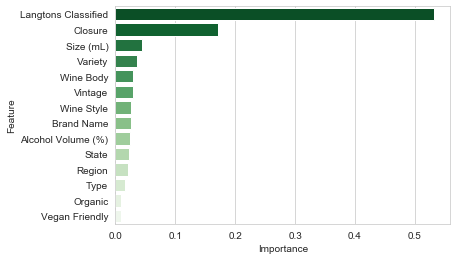

In [42]:
# Fit best model on the entire dataset
xgb_best.fit(df_X, df_y)

# Obtain and plot feature importances
df_importances = pd.DataFrame(xgb_best.feature_importances_, num_features + cat_features).reset_index(drop=False)
df_importances.rename(columns={'index':'Feature', 0:'Importance'}, inplace=True)
df_importances.sort_values(by='Importance', ascending=False, inplace=True)
sns.barplot(x='Importance', y='Feature', data=df_importances, orient='h', palette='Greens_r');

## Conclusion

Key findings of an exploratory data analysis are as follows:
1. Wine prices ranged considerably from $2.99 to $36,000, with the majority ranging between $18.00 and $69.99. The most expensive bottles of wine tended to be Shiraz.
2. Vintage ranged between 1952 to 2018, with the majority ranging between 2008 and 2016.
3. On average, Shiraz was the most expensive wine ($264.03), whereas Sauvignon Blanc was the cheapest ($17.88). However, the average for Shiraz was greatly skewed by outlier wines costing thousands of dollars. When only considering wines less than or equal to $100, the discrepancy was greatly reduced, with the most expensive being Cabernet Sauvignon ($37.28), and Sauvignon Blanc being the cheapest ($17.88).
4. Red wines ($255.04) were more expensive than white wines ($46.25). Similarly, this discrepancy was reduced ($37.42 versus $27.10) when only considering wines less than or equal to $100.
5. South Australian wine was the most costly ($232.65), Queensland was the least ($14.12).	
6. Corkage was the most expensive closure type.
7. Both vegan and organic wines were associated with lower wine prices. This is likely due to the more expensive bottles almost always never being vegan/organic.
8. Unsurprisingly, larger volumes (mL) and superior Langton's classifications carried a higher price.

A predictive model was able to explain 88% of the variance in wine price on a test set. This result is quite a good result given that we have not examined other market dynamics influencing retail price, including place of business and buyer demographics. The most important feature for prediction was Langton's classification, followed by closure type, variety, brand name, and vintage. Watering information taken from an Australian Bureau of Statistics (ABS) dataset showed no relationship with price, suggesting that these factors have little influence on Dan Murphy's product pricing strategy.

Overall, findings shed light on the features associated with Dan Murphy's retail wine prices, which may inform the future pricing strategy of a competitor business. Future models could incorporate the overall development costs of each wine, as this would provide a more complete picture of Dan Murphy's pricing scheme. Teasing apart price markups due to 1) development costs, and 2) wine characteristics (e.g. corkage, vintage) will prove difficult, but should inspire ongoing work.
